03 Using Nipype to load fMRI data
=====================
#### Date: Feb 12 2018; Author: Farahana

## Data Acquisition and Simple Preprocessing
*Part 1*: Data Acquisition for anatomical and functional NifTi images
    
*Part 2*: Simple preprocessing

*Part 3*: Getting the output of pre-processing steps (Datasink and connect the workflows.)

In [1]:
# Base packages
%pylab inline
import numpy as np
#import matplotlib.pyplot as plt
import pandas as pd

# Neuroimaging packages
import nibabel as nib
from nilearn.plotting import plot_img, plot_anat, plot_stat_map
from nipype import SelectFiles, Node, DataSink
from nipype.pipeline.engine import Workflow, MapNode

# We will import the pre-processing process in their parts.

Populating the interactive namespace from numpy and matplotlib


/home/farahana/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Checking the packages version

In [2]:
import sys
import os
import nilearn
print("Python version:", sys.version.split()[0])
print("Nibabel version: ", nib.__version__)
print("Nilearn version:", nilearn.__version__)

Python version: 3.5.4
Nibabel version:  2.2.1
Nilearn version: 0.4.0


#### Some helper functions to be used

In [5]:
# Simple viewer
def plot_nii(in_file):
    nii = nib.load(in_file)
    nii.orthoview()

# Let's create a short helper function to plot 3D NIfTI images
def plot_slice(fname, slice_no):

    # Load the image
    img = nib.load(fname)
    data = img.get_data()

    # Cut in the middle of the brain
    cut = int(data.shape[-2]/2)

    # Plot the data
    imshow(np.rot90(data[:, :, cut, slice_no]), cmap="gray")
    gca().set_axis_off()    

### Part 1: Data Acquisition for anatomical and functional NifTi images

In [6]:
# The template string
templates = { 'anat' : 'sub*/anatomy/highres001.nii*',
              'func' : 'sub*/BOLD/task001_run{ses_no}/bold.nii*'}

# How to address and import using SelectFiles node
sf = Node(SelectFiles(templates),
          name='selectfiles')

sf.inputs.base_directory = '/home/farahana/Documents/dataset/Multi_Subject/ds117'

In [7]:
# Choose the first run for subjects imports
sf.inputs.ses_no = "001"

To view the import, use 
~~~
sf.run().outputs
~~~

However, we will run this using the connect/workflow of Nipype together 
with other pre-processing steps.

Visualizing the input data folder

In [ ]:
!tree /home/farahana/Documents/dataset/Multi_Subject/ds117

### Part 2: Simple preprocessing
*Step 1*: Brain extractions
    
*Step 2*: Realignment

In [8]:
# Import BET from the FSL interface
from nipype.interfaces.fsl import (BET, IsotropicSmooth, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface

# Import Retroicor from the SPM interface
from nipype.interfaces.spm import Realign

#### Let us try with 1 subject 1 task pre-processing

In [9]:
# Define the subject chosen and initialize it
input_file = "/home/farahana/Documents/dataset/Multi_Subject/ds117/sub003/BOLD/task001_run001/bold.nii"

In [12]:
skullstrip_sub3 = BET(in_file = input_file,
                     out_file = "output/sub-03_brain.nii.gz",
                      functional= True,
                     mask = True)

# Run this to get the output for the input of next step
%time skullstrip_sub3.run()

CPU times: user 132 ms, sys: 24 ms, total: 156 ms
Wall time: 7.48 s


In [13]:
smooth_sub3 = IsotropicSmooth(in_file = "output/sub-03_brain.nii.gz",
                            out_file = "output/sub-03_smooth.nii.gz",
                            fwhm=4)

%time smooth_sub3.run()

CPU times: user 136 ms, sys: 28 ms, total: 164 ms
Wall time: 7.36 s


In [14]:
motcor_sub3 = MCFLIRT(in_file = "output/sub-03_smooth.nii.gz",
                            out_file = "output/sub-03_mcflirt.nii.gz",
                     cost='mutualinfo')

%time motcor_sub3.run()

CPU times: user 204 ms, sys: 60 ms, total: 264 ms
Wall time: 44.5 s


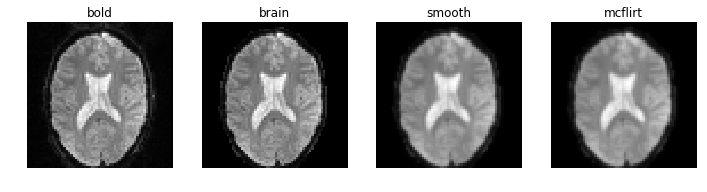

In [15]:
f = plt.figure(figsize=(12, 4))
for i, img in enumerate(["bold", "brain","smooth", "mcflirt"]):
    f.add_subplot(1, 4, i + 1)
    if i == 0:
        plot_slice("/home/farahana/Documents/dataset/Multi_Subject/ds117/sub003/BOLD/task001_run001/%s.nii" % img, 1)
    else:
        plot_slice("output/sub-03_%s.nii.gz" % img, 1)
    plt.title(img)

#### Now, let us try with many subjects

In [ ]:
# Initiation of a workflow
wf = Workflow(name="preproc", base_dir="/output/working_dir")

In [ ]:
# Workflow of pre-processing steps
skullstrip = Node(BET(output_type='NIFTI_GZ',
                      name="skullstrip"))

smooth = Node(IsotropicSmooth(output_type='NIFTI_GZ',
                              name="smooth"))

wf.connect([()])
              
              